From: https://github.com/keyonvafa/Gaussian-Process

In [23]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
%matplotlib inline

In [24]:
rcParams['figure.figsize'] = (10.0, 7.0)
sns.set_style("whitegrid")
sns.set_context("notebook")

# Gaussian process regression

Add some toy data to perform regression over.

In [6]:
x = np.array([-1.5,-.9,-.75,-.6,-.25,0])
y = np.array([-1.8,-1.2,-.3,.2,.5,.6])

Plot to see distribution

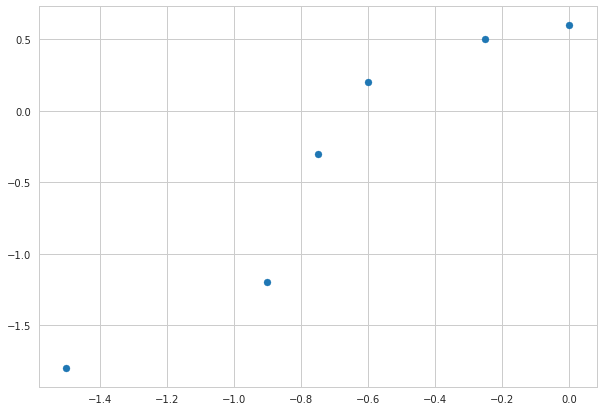

In [25]:
plt.scatter(x,y)

Setup a linear regression model to test

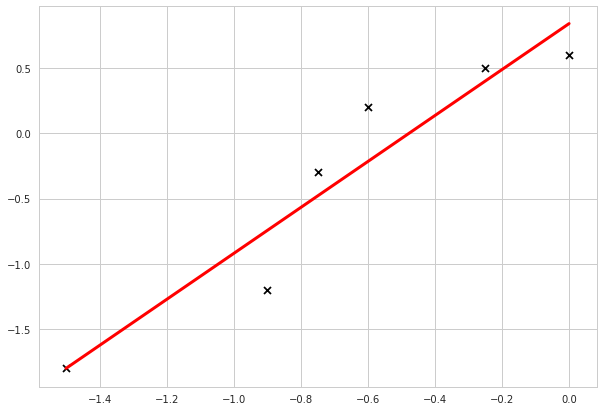

In [39]:
x_train = [[x[i]] for i in range(len(x))]
y_train = [[y[i]] for i in range(len(y))]
# instantiate model
linreg = linear_model.LinearRegression()
# fit model with data
linreg.fit(x_train,y_train)
# visualise fit on data
plt.scatter(x,y,marker='x',color='k')
plt.plot(x_train,linreg.predict(x_train),color='r',lw=3)

Pretty poor fit overall.

### Use GP with optimised hyperparamters for this model class

In [60]:
# fold noise into the kernel by using the Kroenecker delta iff x == xx
x = np.array([-1.5,-.9,-.75,-.6,-.25,0])
y = np.array([-1.8,-1.2,-.3,.2,.5,.6])
sigma_n = np.var(y)
n = len(y)

In [58]:
# build funky kernel (still not sure why this one was used)
def kernel(x,xx,theta1,theta2):
    """
    x :: first independent input
    xx :: second independent input
    """
    l = np.exp(theta1)
    sigma = np.exp(2*theta2)
    # Kroenecker delta used on far right
    return sigma * np.exp( -((x - xx) ** 2)/l ) + sigma_n*int(x == xx)

def make_K(theta1,theta2):
    """
    Populate covariance matrix (i.e. initialise for optimisation)
    """
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = kernel(x[i],x[j],theta1,theta2)
    return K

# first partial derivative
def dK_theta1(theta1,theta2):
    l = np.exp(theta1)
    sigma = np.exp(2*theta2)
    # partial derivatives in a matrix
    K = np.zeros((n,n))
    for x in range(n):
        for xx in range(n):
            K[i,j] = sigma*np.exp((-(x[i]-x[j])**2)/l)*((x[i]-x[j])**2)/l
    return K

# second partial derivative
def dK_theta2(theta1,theta2):
    l = np.exp(theta1)
    sigma = np.exp(2*theta2)
    # partial derivatives in a matrix
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = 2*sigma*np.exp((-(x[i]-x[j])**2)/l)
    return K

# Log likelihood gradient 
def logLikGrad(theta1,theta2):
    w = np.zeros(2) # of size two since we only have two hypers in kernel
    K = make_K(theta1,theta2)
    Kinv = np.linalg.inv(K) # get inverse 
    
    